In [202]:
from jupyterthemes import jtplot
jtplot.style(theme='monokai')
import numpy as np
import pandas as pd

# input data==================================================================
data = pd.read_csv("./Patient_Statistics.csv", encoding="shift-jis")
data = data.dropna(how="any")
# translate string into datetime==============================================
import datetime
for i in range(len(data)):
    day = data["日付"].iloc[i].split("/")
    data["日付"].iloc[i] = datetime.date(int(day[0]),int(day[1]),int(day[2]))
# print(day)
# drop nan====================================================================
print(data.head(-1))
# print(data.dtypes)
for i in range(1,len(data.columns)):
    for j in range(len(data)):
        if isinstance(data.iloc[j,i], str):
            data.iloc[j,i] = int(data.iloc[j,i].replace(',', ''))
    data.iloc[:,i].astype(np.int32)
data_days = data["日付"]
data = data.set_index("日付")
print(data.head(-1))
print(data.dtypes)

C:\Users\owner\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


             日付 日本国内\n累計罹患者数 日本国内\n新規罹患者数 北海道  青森県  岩手県  宮城県  秋田県  山形県  福島県  \
1    2020-01-16            1            1   0    0    0    0    0    0    0   
2    2020-01-17            1            0   0    0    0    0    0    0    0   
3    2020-01-18            1            0   0    0    0    0    0    0    0   
4    2020-01-19            1            0   0    0    0    0    0    0    0   
5    2020-01-20            1            0   0    0    0    0    0    0    0   
..          ...          ...          ...  ..  ...  ...  ...  ...  ...  ...   
135  2020-05-29        16832           74   3    0    0    0    0    0    0   
136  2020-05-30        16877           45   4    0    0    0    0    0    0   
137  2020-05-31        16912           35   6    0    0    0    0    0    0   
138  2020-06-01        16949           37   5    0    0    0    0    0    0   
139  2020-06-02        17000           51   3    0    0    0    0    0    0   

     ...  愛媛県  高知県  福岡県 佐賀県  長崎県 熊本県 大分県  宮崎県  鹿児島県

C:\Users\owner\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':


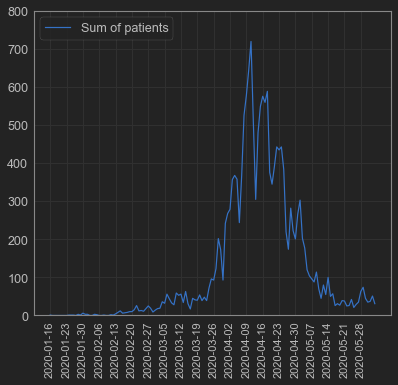

In [203]:
import matplotlib.pyplot as plt
fig = plt.Figure(figsize=(30,10))
x = data_days
y = np.array(data["日本国内\n新規罹患者数"]).astype(int)
# print(y)
plt.xlabel = "日付"
plt.ylabel = "新感染者数"
plt.plot(x,y,label="Sum of patients")
plt.subplot().set_ylim([0,800])
plt.xticks(x[::7], rotation=90, size='small')
plt.legend(loc="upper left")
plt.show()

C:\Users\owner\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


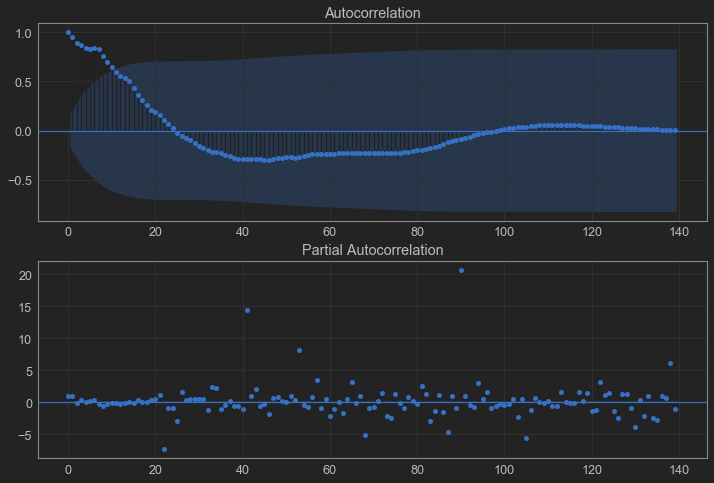

In [204]:
# コレログラム=================================================================
import statsmodels.api as sm
days = data["日本国内\n新規罹患者数"]
# print(days)
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
# 自己相関係数（ACF: Autocorrelation Function）
fig = sm.graphics.tsa.plot_acf(days, lags=len(data)-1, ax=ax1)
ax2 = fig.add_subplot(212)
# 偏自己相関係数（PACF:Pertial Autocorrelation Function）
fig = sm.graphics.tsa.plot_pacf(days, lags=len(data)-1, ax=ax2)

[ 0.23587272  0.27485484 -0.18131414  0.01655107 -0.20242555 -0.16829919]


C:\Users\owner\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


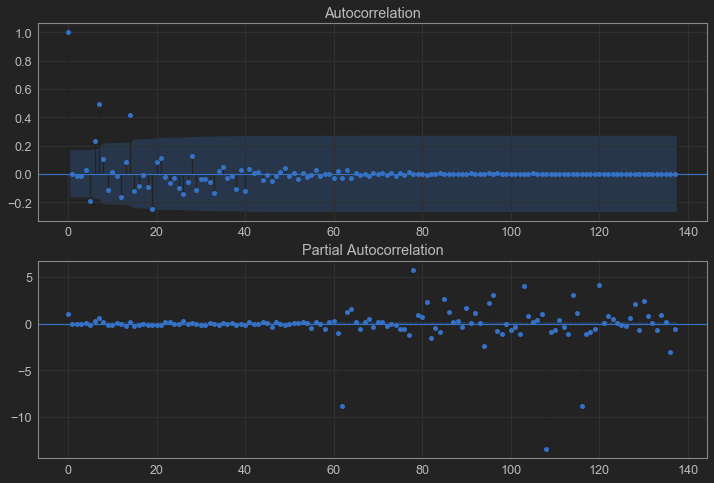

In [205]:
resDiff = sm.tsa.arma_order_select_ic(days, ic='aic', trend='nc')
from statsmodels.tsa.arima_model import ARIMA
ar = ARIMA(days.values, order=(3, 1, 2)).fit(dist=False)
print(ar.params)
resid = ar.resid
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid.squeeze(), lags=len(data)-3, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid, lags=len(data)-3, ax=ax2)

In [199]:
ar_pred = ar.predict(start=2020_06_03,end=2020_06_04)

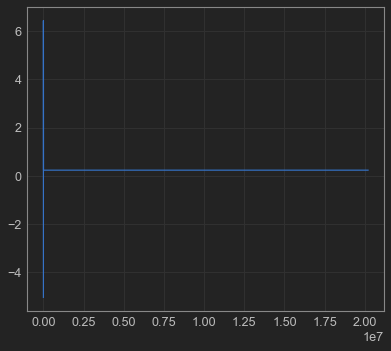

In [201]:
plt.plot(ar_pred)
plt.show()

In [116]:
train = [[range(1,data+1)]]
target = data["日本国内\n新規罹患者数"]
# print(X_train,X_valid)
# print(X_train.shape, Y_train.shape)

#tomorrow predict============================================================
X_train, Y_train, X_target, Y_target = \
train.values[:-2], train.values[-1].reshape(1, -1), target.values[:-2], target.values[-1]

from sklearn import svm
svr = svm.SVR(C=155,kernel="rbf", epsilon=0.9)
svr.fit(X_train, X_target)

# plot===================================
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

x1 = range(1,data)
x2 = range(1,data+1)
# print(x2)
pred1 = svr.predict(X_train).round(0)
pred2 = svr.predict(Y_train).round(0)    
y1 = target
y2 = np.concatenate([pred1, pred2])

first_year = data["日付"].values[0].year
first_month = data["日付"].values[0].month
first_day = data["日付"].values[0].day
x2 = pd.DataFrame([datetime.date()], index=[str(len(data)+1)])
x2 = data["日付"].append(x2)

ax.plot(x1,y1)
ax.plot(x2,y2,color="red")
# ax.set_xticklabels(x, rotation=90, size='small')
plt.show()
# ==========================================================================



SyntaxError: invalid syntax (<ipython-input-116-217f4f13534c>, line 18)

ValueError: x and y must have same first dimension, but have shapes (931,) and (133,)

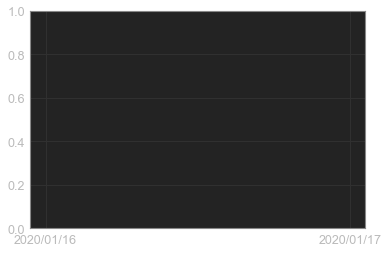

In [335]:
svr.fit(train,target)

pred = svr.predict(train).round(0)
# print(sum(abs(target-pred)))
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
x = range(len(data))
# to date
for i in range(len(data)):
    x1.append(data.iat[i,0])
for i in range(len(X_train)+len(Y_train)):
    x2.append(data.iat[i,0])
    
y1 = target
y2 = pred
ax.plot(x1,y1)
ax.plot(x1,y2,color="red")
ax.set_xticks(x1[::7])
plt.show()